## Dataset
Dataset consists of 60000 32x32 colour images.
Image belong to 10 classes, with 6000 images per classs.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


In [1]:
# Import dependecies
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np

## Data Preprocessing

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [3]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [4]:
all_data = [0,1,2,3,4,5,6]

In [5]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle('data_batches/%s'%direc)

In [6]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [7]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [8]:
data_batch1.keys()

dict_keys([b'batch_label', b'filenames', b'data', b'labels'])

In [9]:
# length of single image before rreshaping
len(data_batch1[b"data"][0])

3072

In [10]:
#get image data from first batch
X = data_batch1[b"data"] 

In [11]:
#reshape and transpose to display image using imshow
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

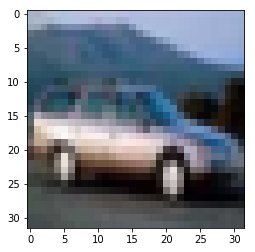

In [12]:
#Display sample Image
plt.imshow(X[4])

In [13]:
# ENcode lablels to One-hot format
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [14]:
# Helper functions to prepare data to feeding into the model
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # List of all the data batches for training and testing
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # vertically stack training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshape and normalizes the training images 
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # vertically stack test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshape and normalizes the test images 
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [15]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


### CNN Model

In [16]:
# Create Placeholdes to feed data
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [17]:
hold_prob = tf.placeholder(tf.float32)

In [18]:
# some helper function
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [19]:
# layer 1 convolution layer and pooling layers
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [20]:
# layer 2 convolution layer and pooling layers
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [21]:
# create flatten layer by reshaping the pooling layer into [-1,8*8*64] or [-1,4096]
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [22]:
# create fully connected layer with 1024 neurons by passing flattened layer
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [23]:
# dropout layer
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [24]:
#predicted values
y_pred = normal_full_layer(full_one_dropout,10)

## Loss function (cross entropy)

In [25]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred))

## Optimizer ( Adam optimizer)

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train = optimizer.minimize(cross_entropy)

## Graph Session

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.0992


Currently on step 100
Accuracy is:
0.4165


Currently on step 200
Accuracy is:
0.4344


Currently on step 300
Accuracy is:
0.4955


Currently on step 400
Accuracy is:
0.516


Currently on step 500
Accuracy is:
0.5515


Currently on step 600
Accuracy is:
0.561


Currently on step 700
Accuracy is:
0.5888


Currently on step 800
Accuracy is:
0.601


Currently on step 900
Accuracy is:
0.5986


Currently on step 1000
Accuracy is:
0.6252


Currently on step 1100
Accuracy is:
0.6223


Currently on step 1200
Accuracy is:
0.6158


Currently on step 1300
Accuracy is:
0.6399


Currently on step 1400
Accuracy is:
0.631


Currently on step 1500
Accuracy is:
0.6499


Currently on step 1600
Accuracy is:
0.6597


Currently on step 1700
Accuracy is:
0.661


Currently on step 1800
Accuracy is:
0.6714


Currently on step 1900
Accuracy is:
0.6701


Currently on step 2000
Accuracy is:
0.6798


Currently on step 2100
Accuracy is:
0.6785


Currently on step 2200
Accu

KeyboardInterrupt: 